# Работа с временнЫми последовательностями

## Введение

- Объекты приходят последовательно во времени
- Хотим предсказывать какую-то информацию об объектах, которая будет в далёком будущем
- Фиксированный (обычно во времени) порядок всех объектов (отличие от обычной задачи предсказания)
- Может быть как задачей регрессии, так и задачей классификации
- В данной лекции будет рассматриваться только случай регрессии. Переход к классификации не должен составить труда

$y_0, y_1, y_2, ..., y_n$ &#151; временной ряд, $y_i \in \mathbb{R}$ &#151; значение, полученное через **постоянный** временной интервал.

$y_{T+d} \approx f_T(y_0, y_1, ..., y_T, \theta, d), d = 1, ..., D$ &#151; модель временного ряда,

где $\theta$ &#151; параметры модели, $D$ &#151; горизонт прогнозирования. 

При $K = 1$ хотим предсказывать только одно следующее значение, в противном случае предсказываем упорядоченный набор $y_{t+1}, y_{t+2}, ..., y_{t+K}$.

В классической задаче анализа данных мы предполагаем независимость всех наблюдений. В случае анализа временных рядов мы исходим из гипотезы о том, что предсказываемое значение зависит от предыдущих.

## Пример задача прогнозирования:

1. курс валюты;
2. стоймость акций компании "Яндекс";
3. спрос на определённый продукт;
4. количество студентов без долгов в определенный момент времени;
5. процент посещаемости лекций по мат. анализу;
6. уровень безработицы;
7. ...

## Термины из области анализа временных рядов:

1. тренд;
2. сезонность, цикл;
3. ошибка.

In [1]:
from IPython.display import Image

### Тренд &#151; изменение значений ряда в долгосрочной преспективе

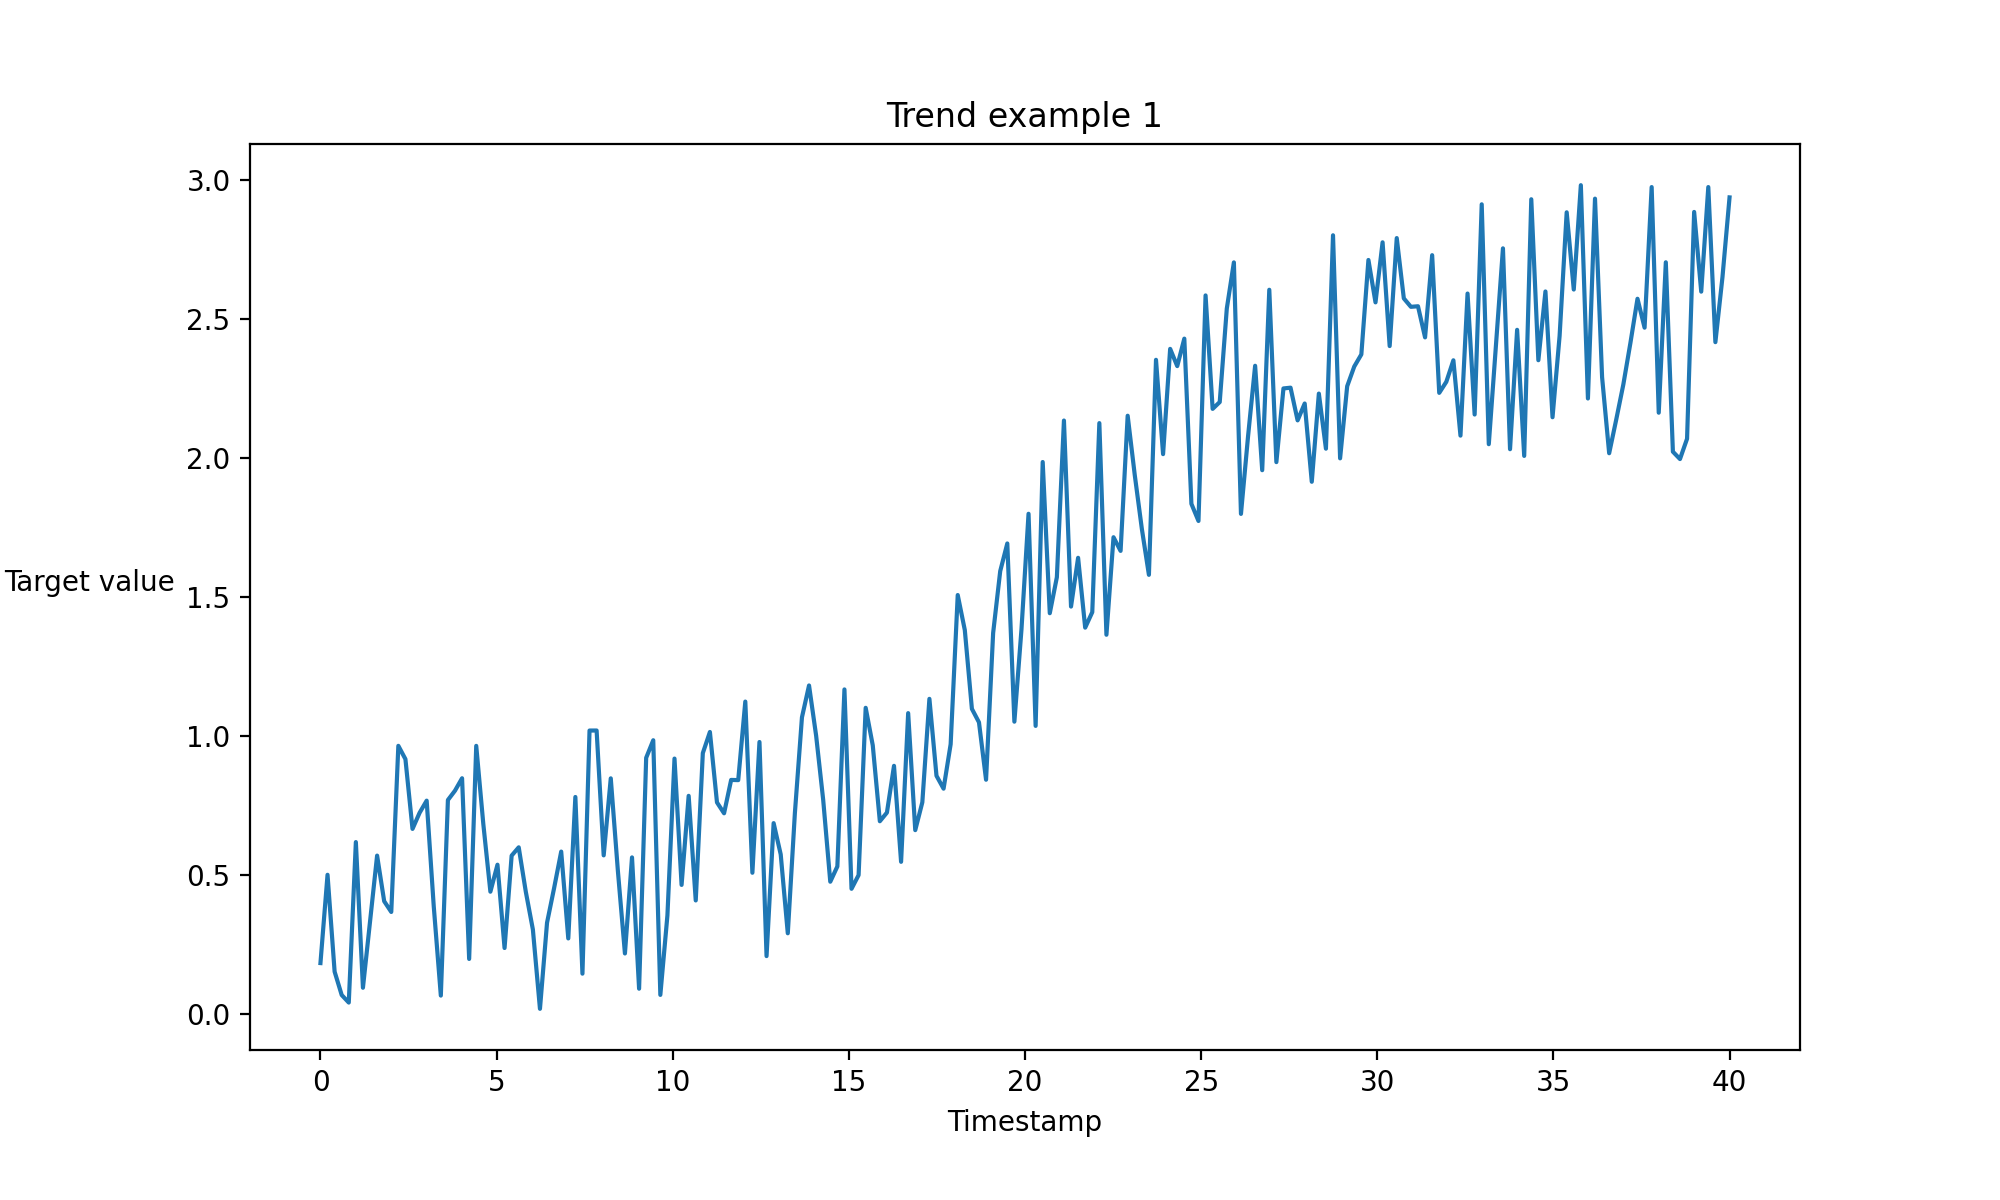

In [2]:
Image('./example_1.png')

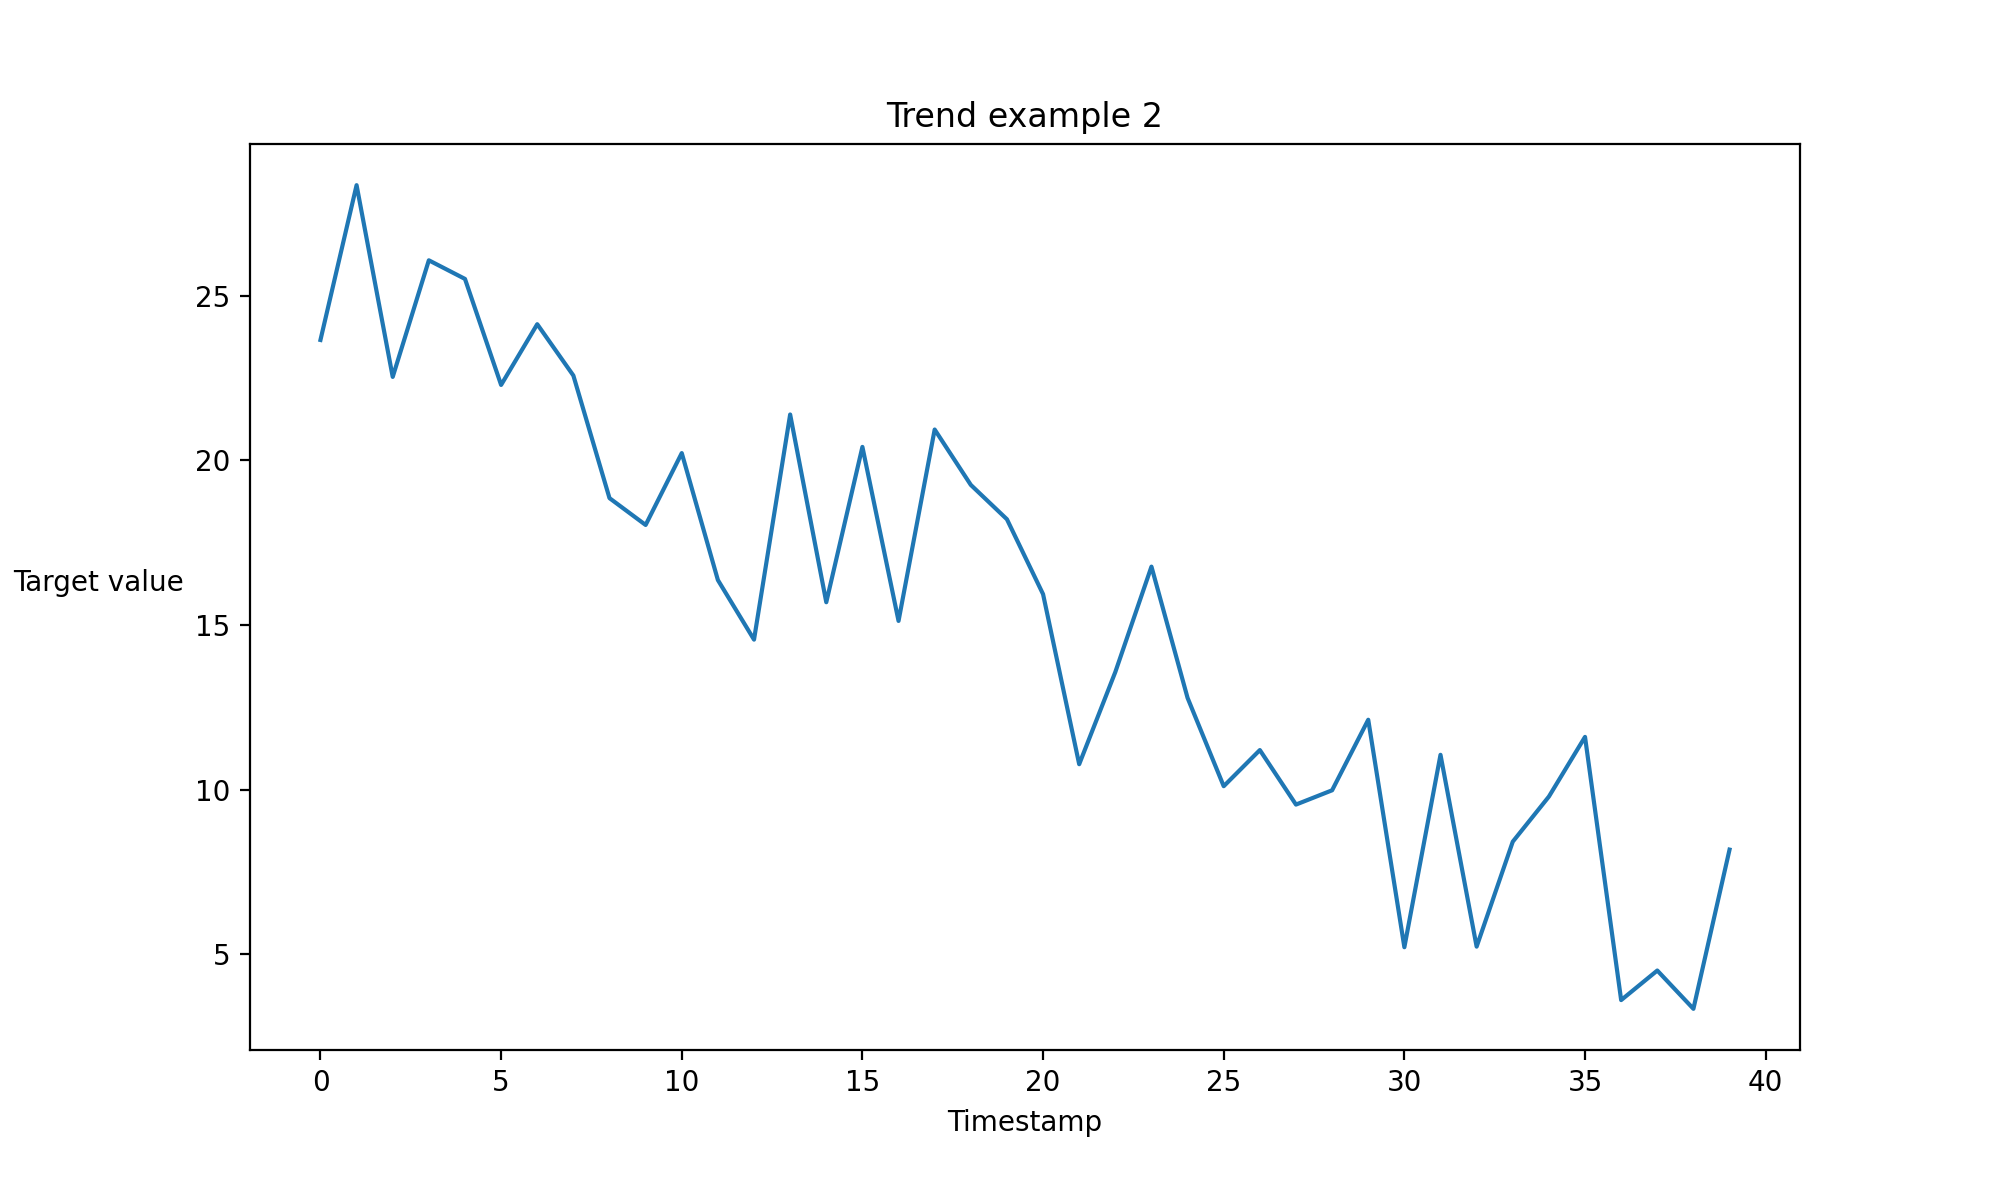

In [3]:
Image('./example_2.png')

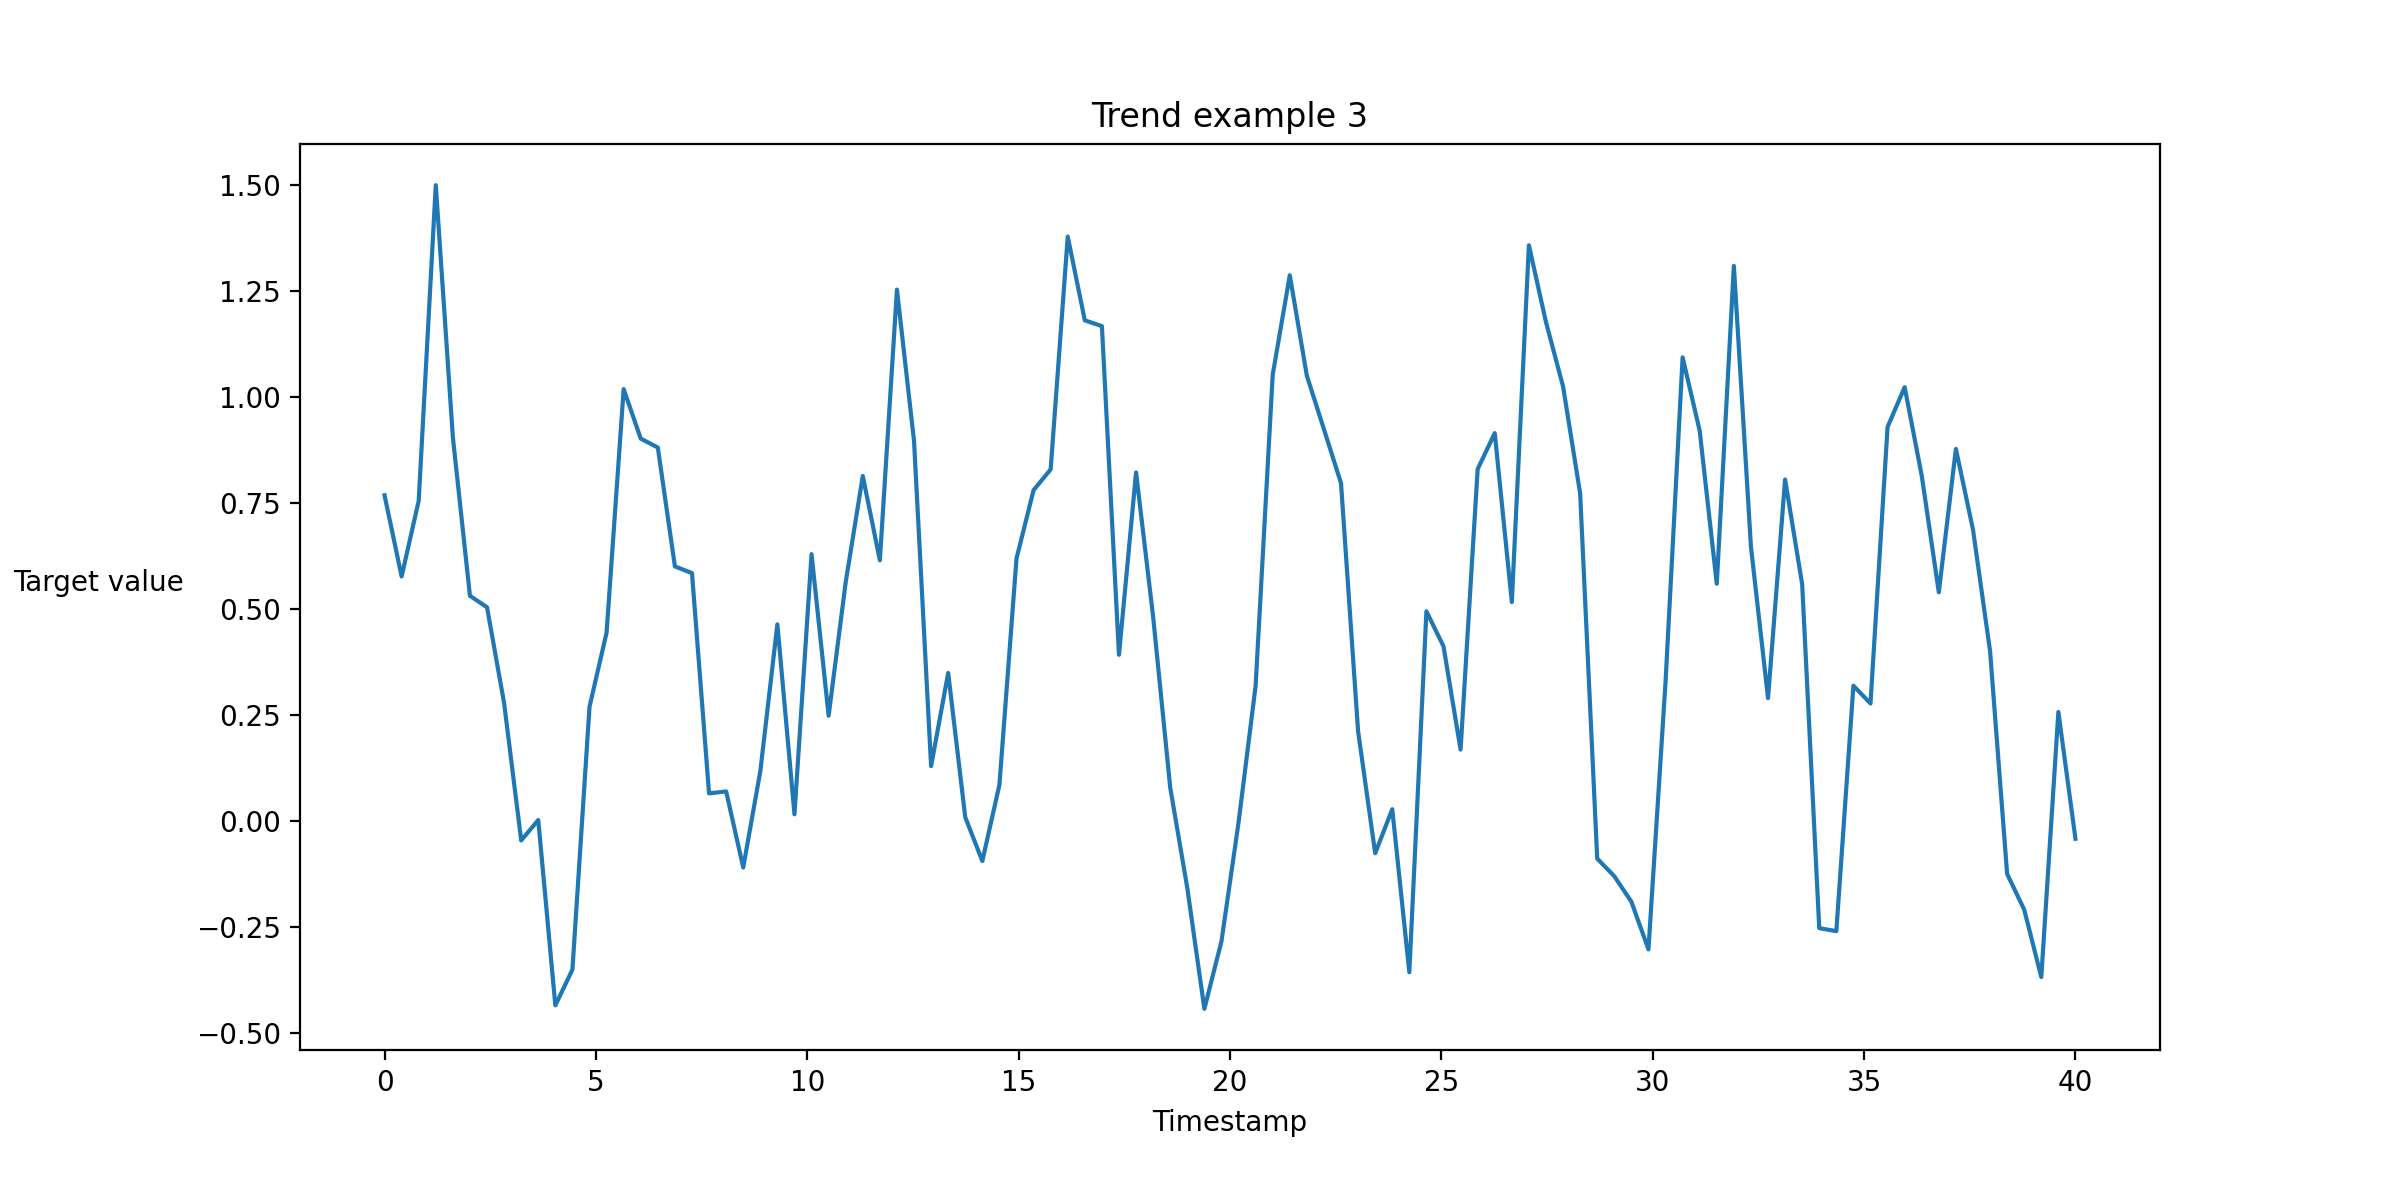

In [4]:
Image('./example_3.png')

### Сезонность &#151; циклические изменения значений ряда с *определённым* периодом

### Цикл &#151; циклические изменения значений ряда с *изменяемым* периодом

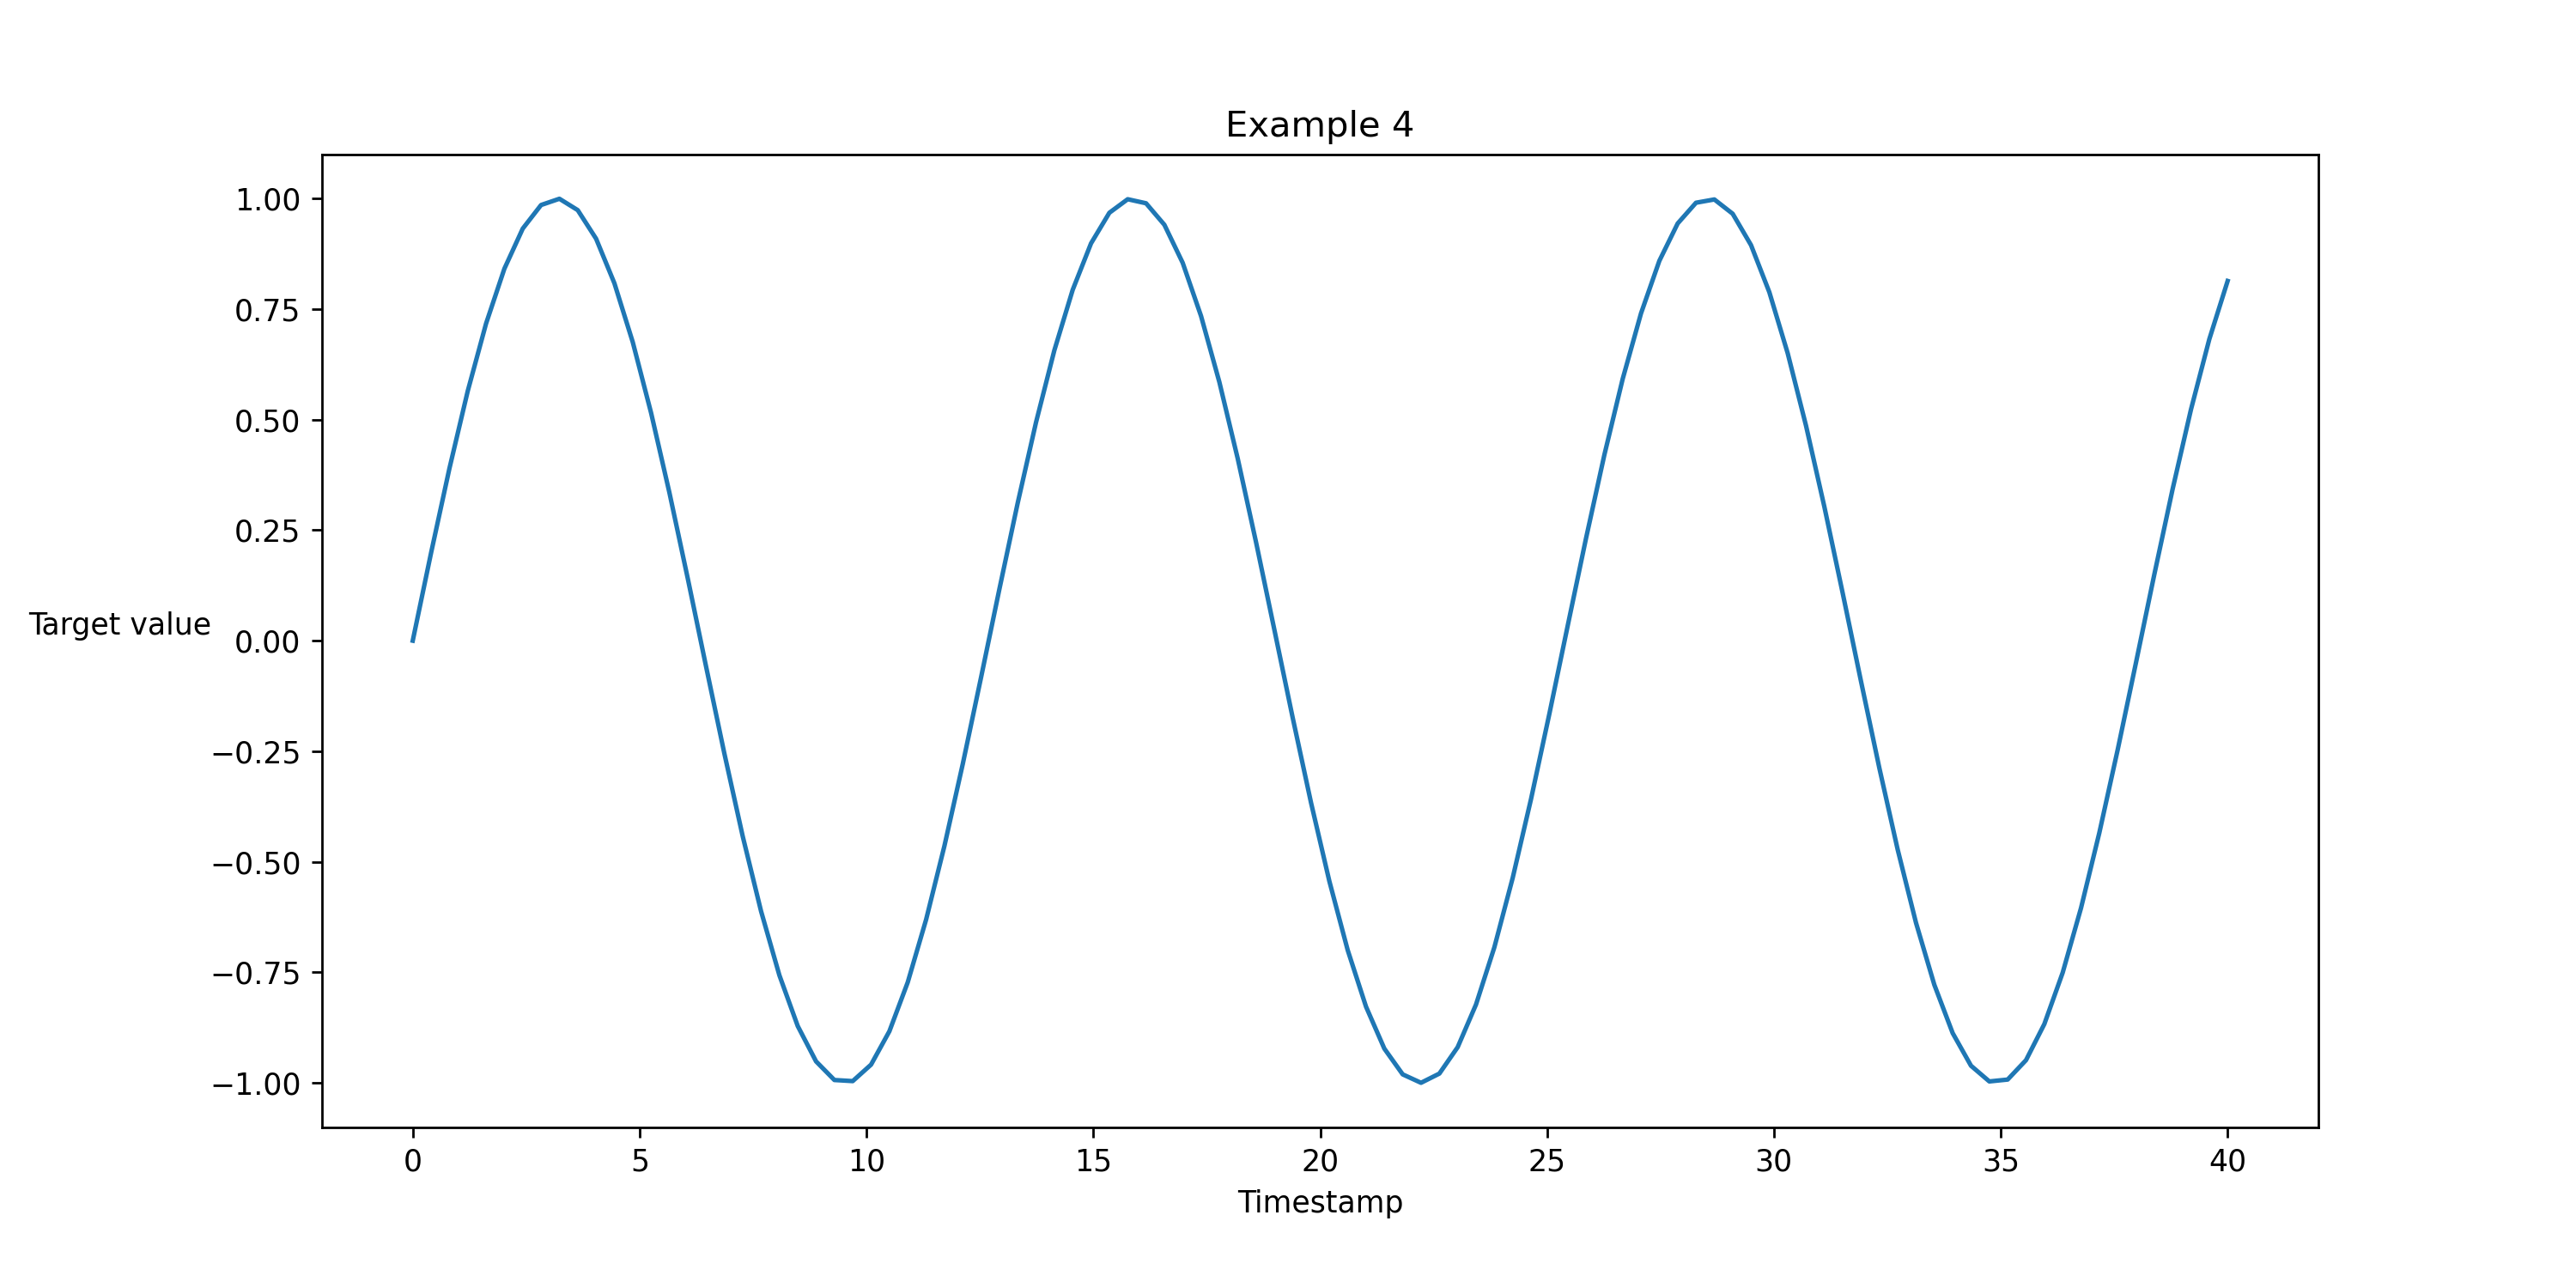

In [5]:
Image('./example_4.png')

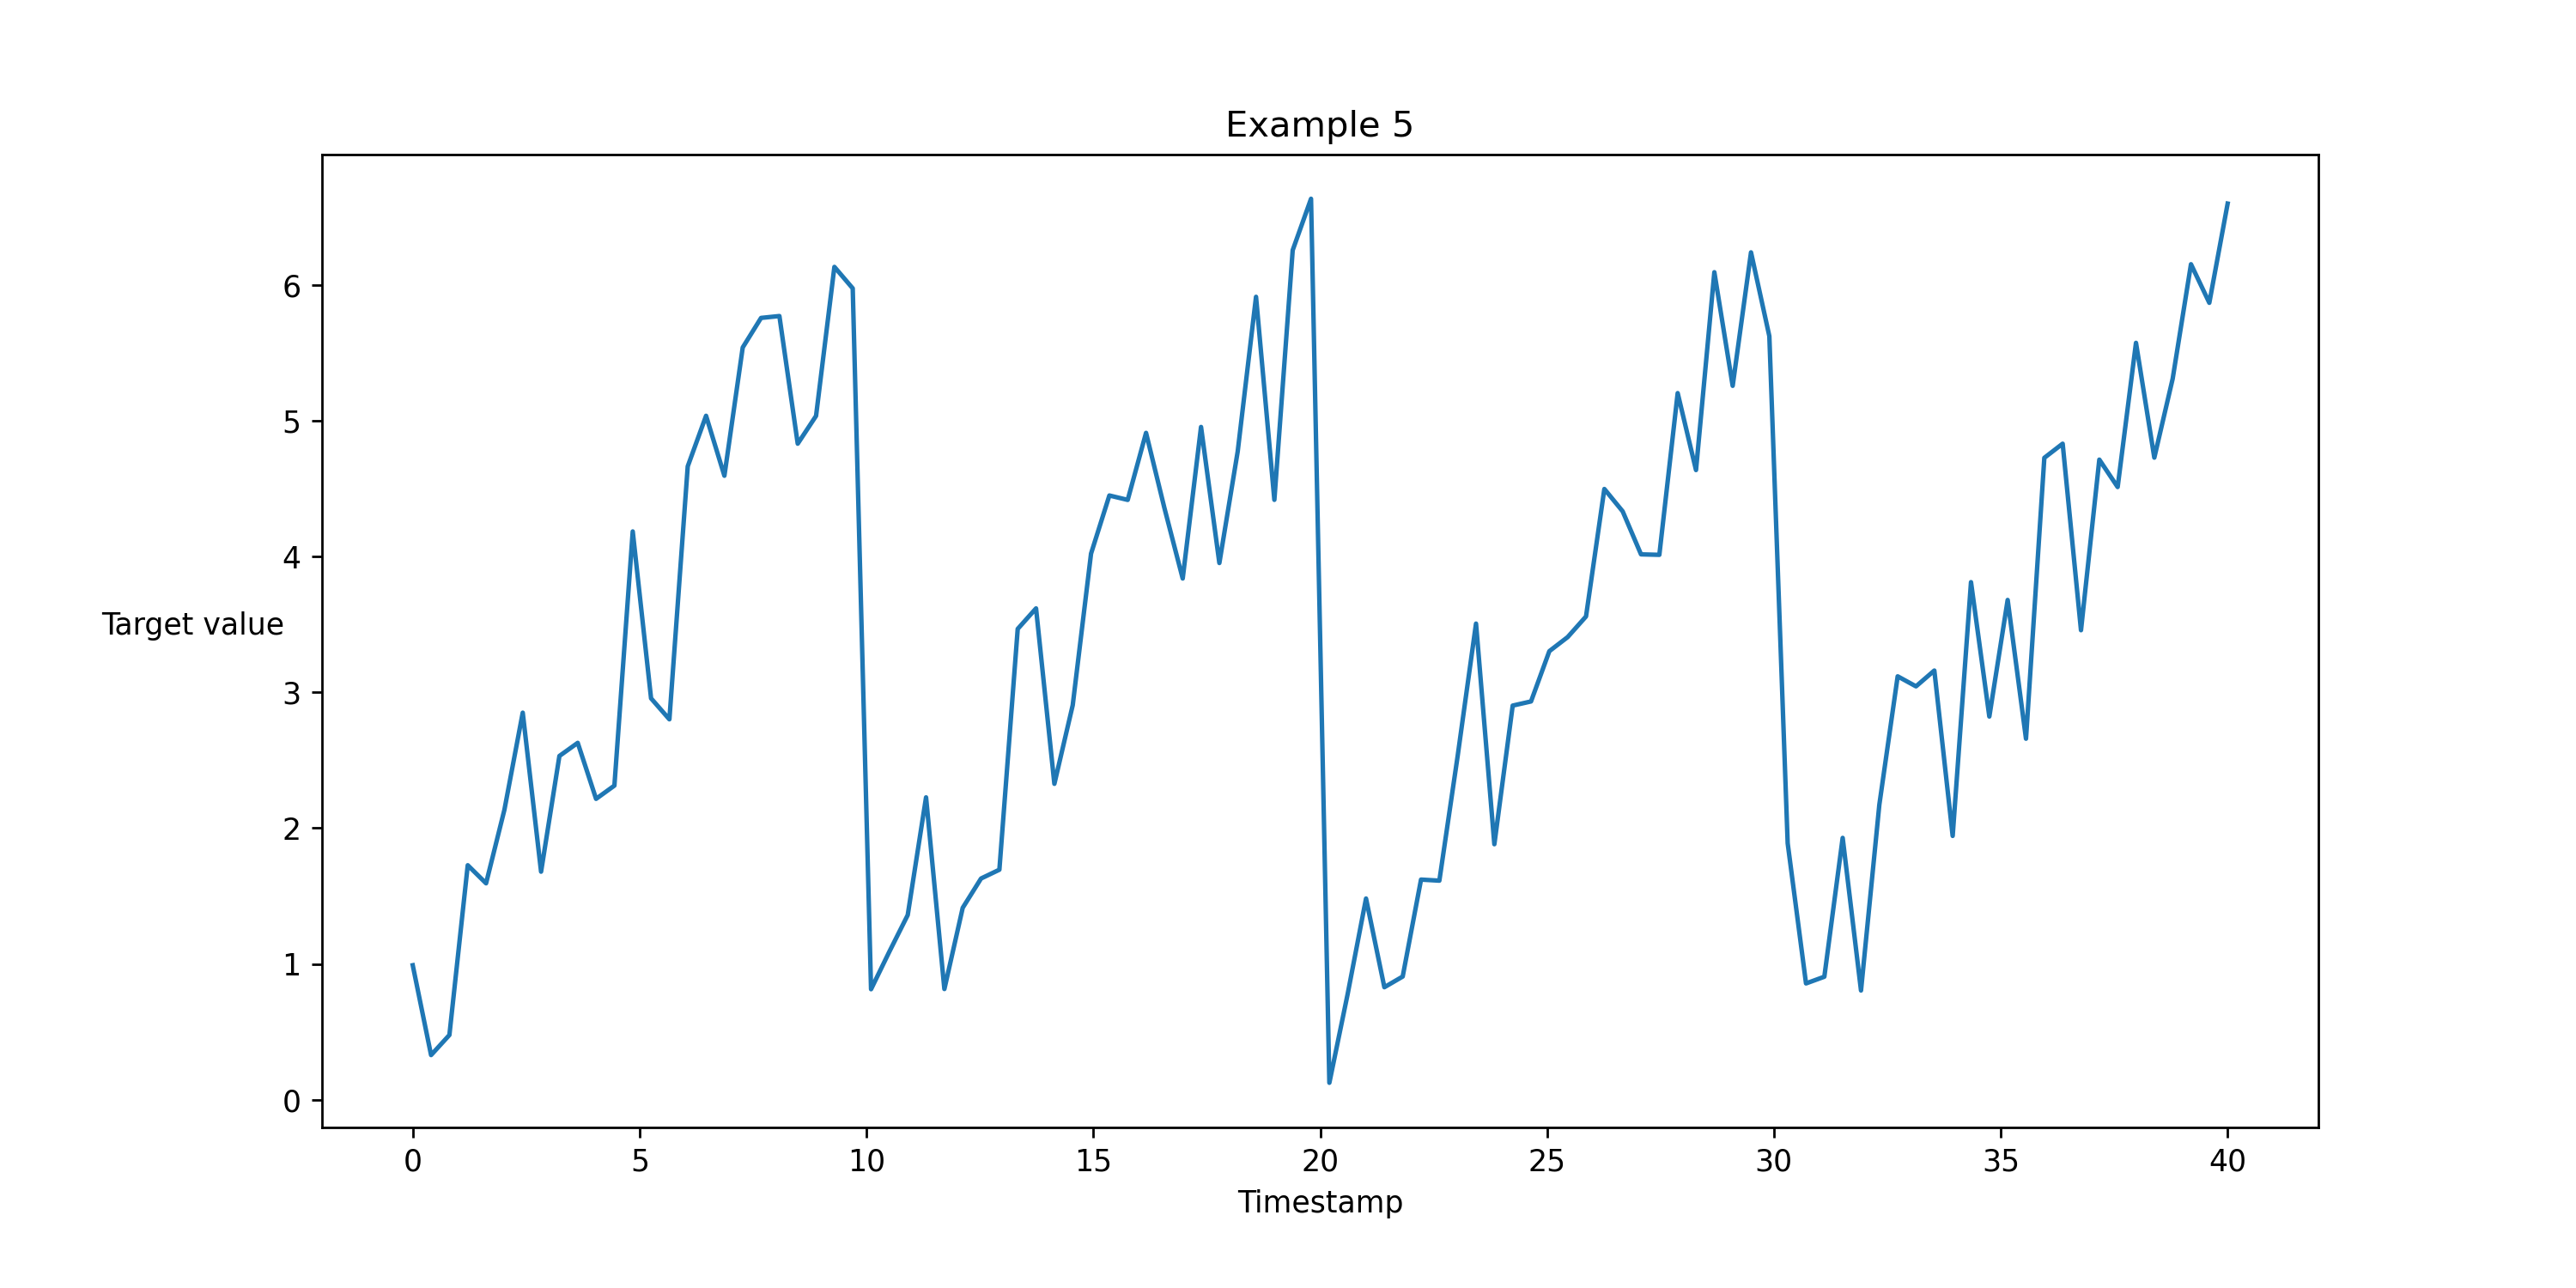

In [6]:
Image('./example_5.png')

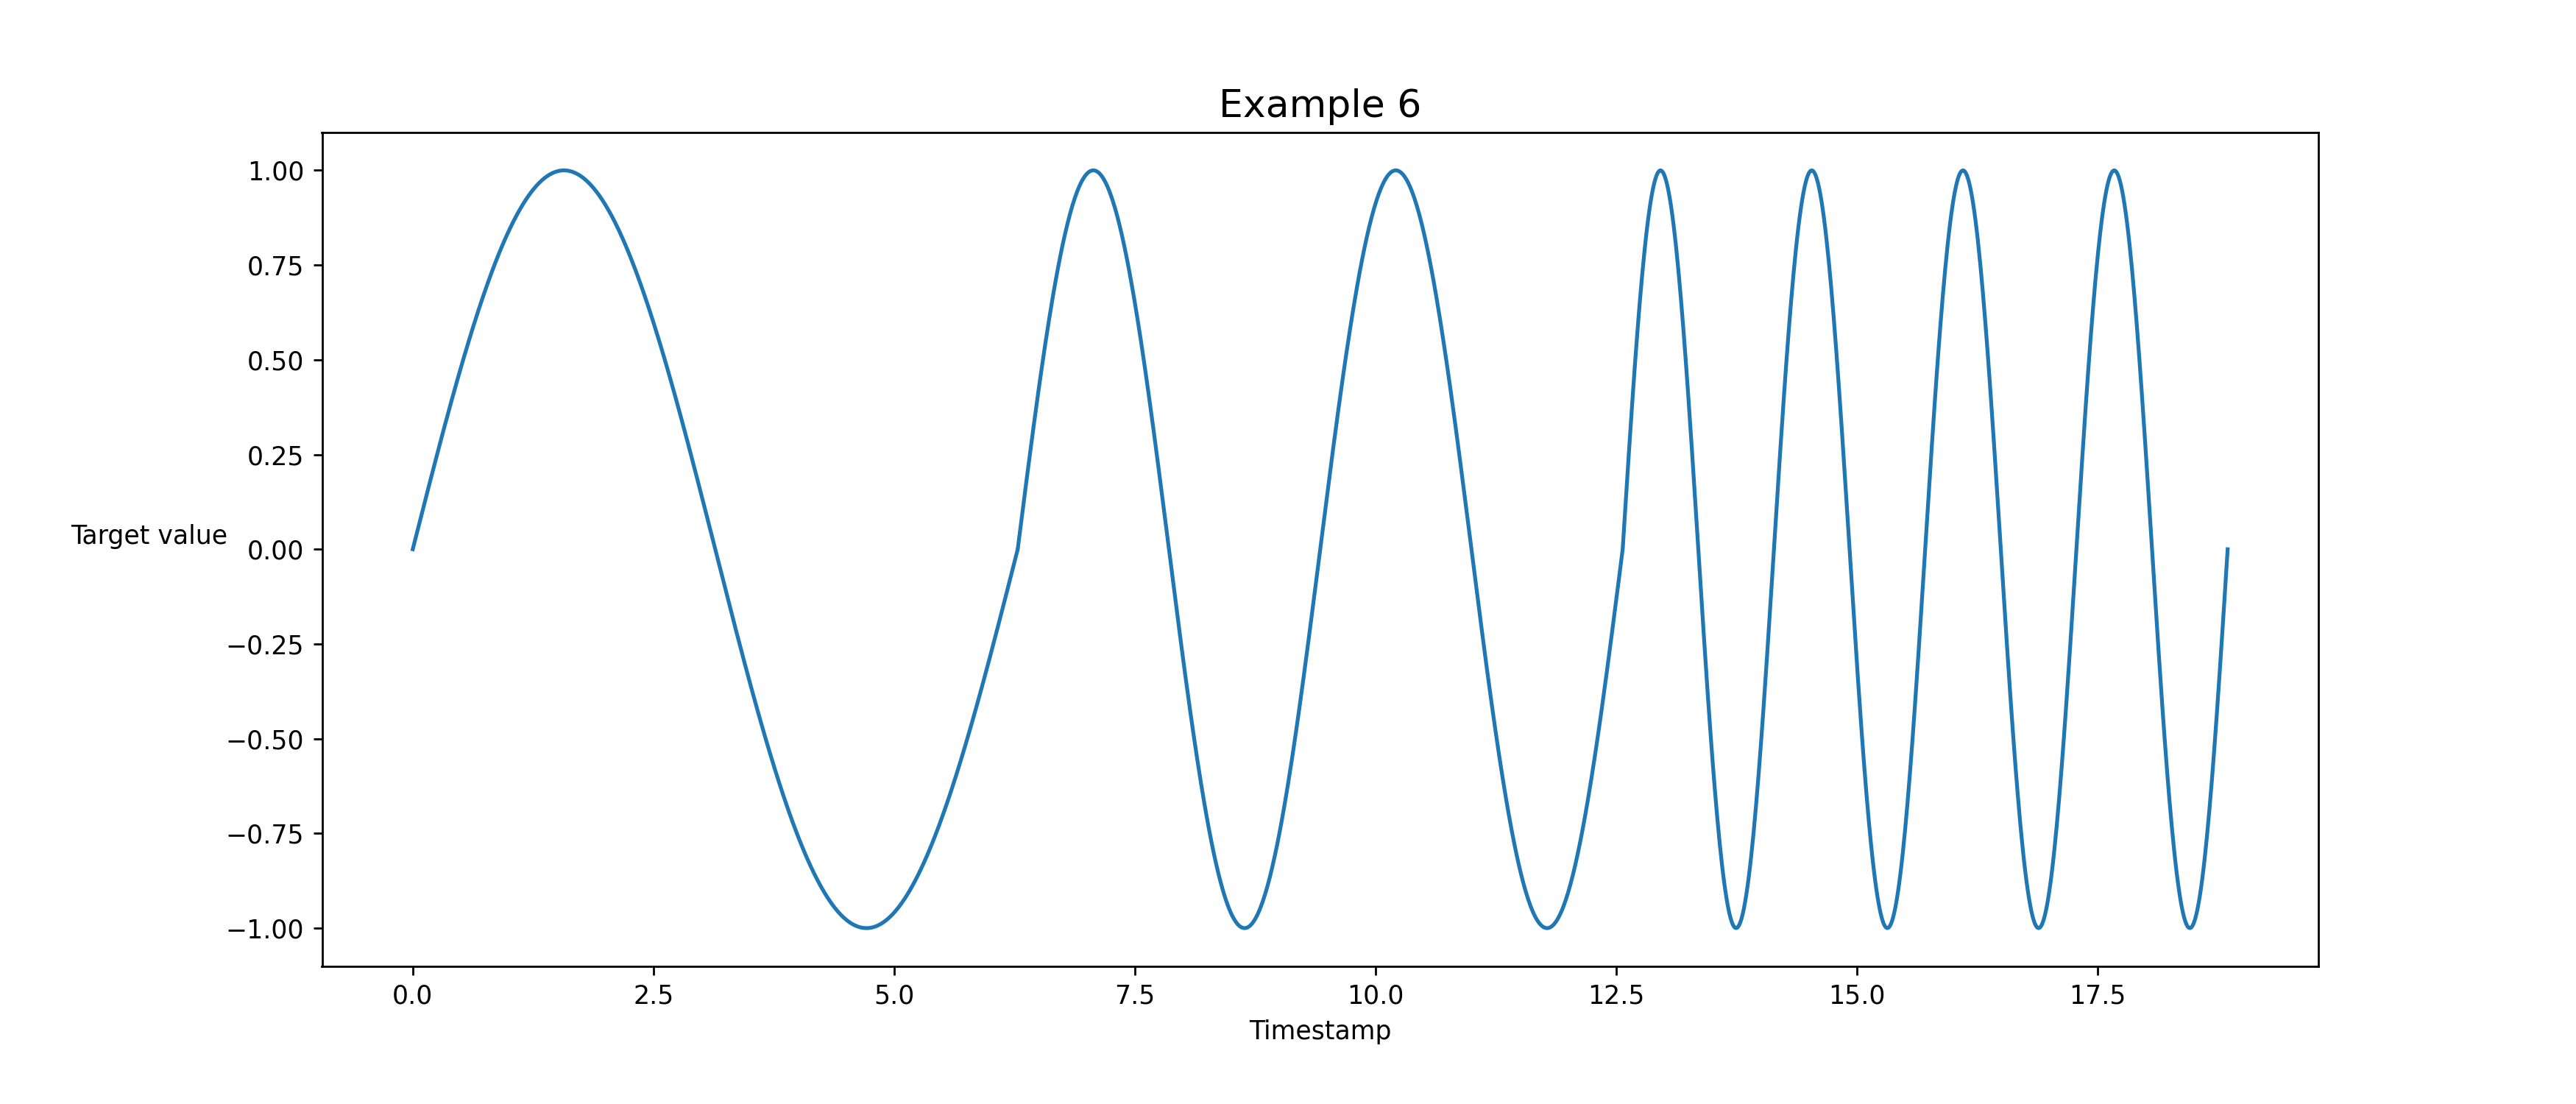

In [7]:
Image('./example_6.png')

### Ошибка &#151; непрогнозируеммая величина, шум.

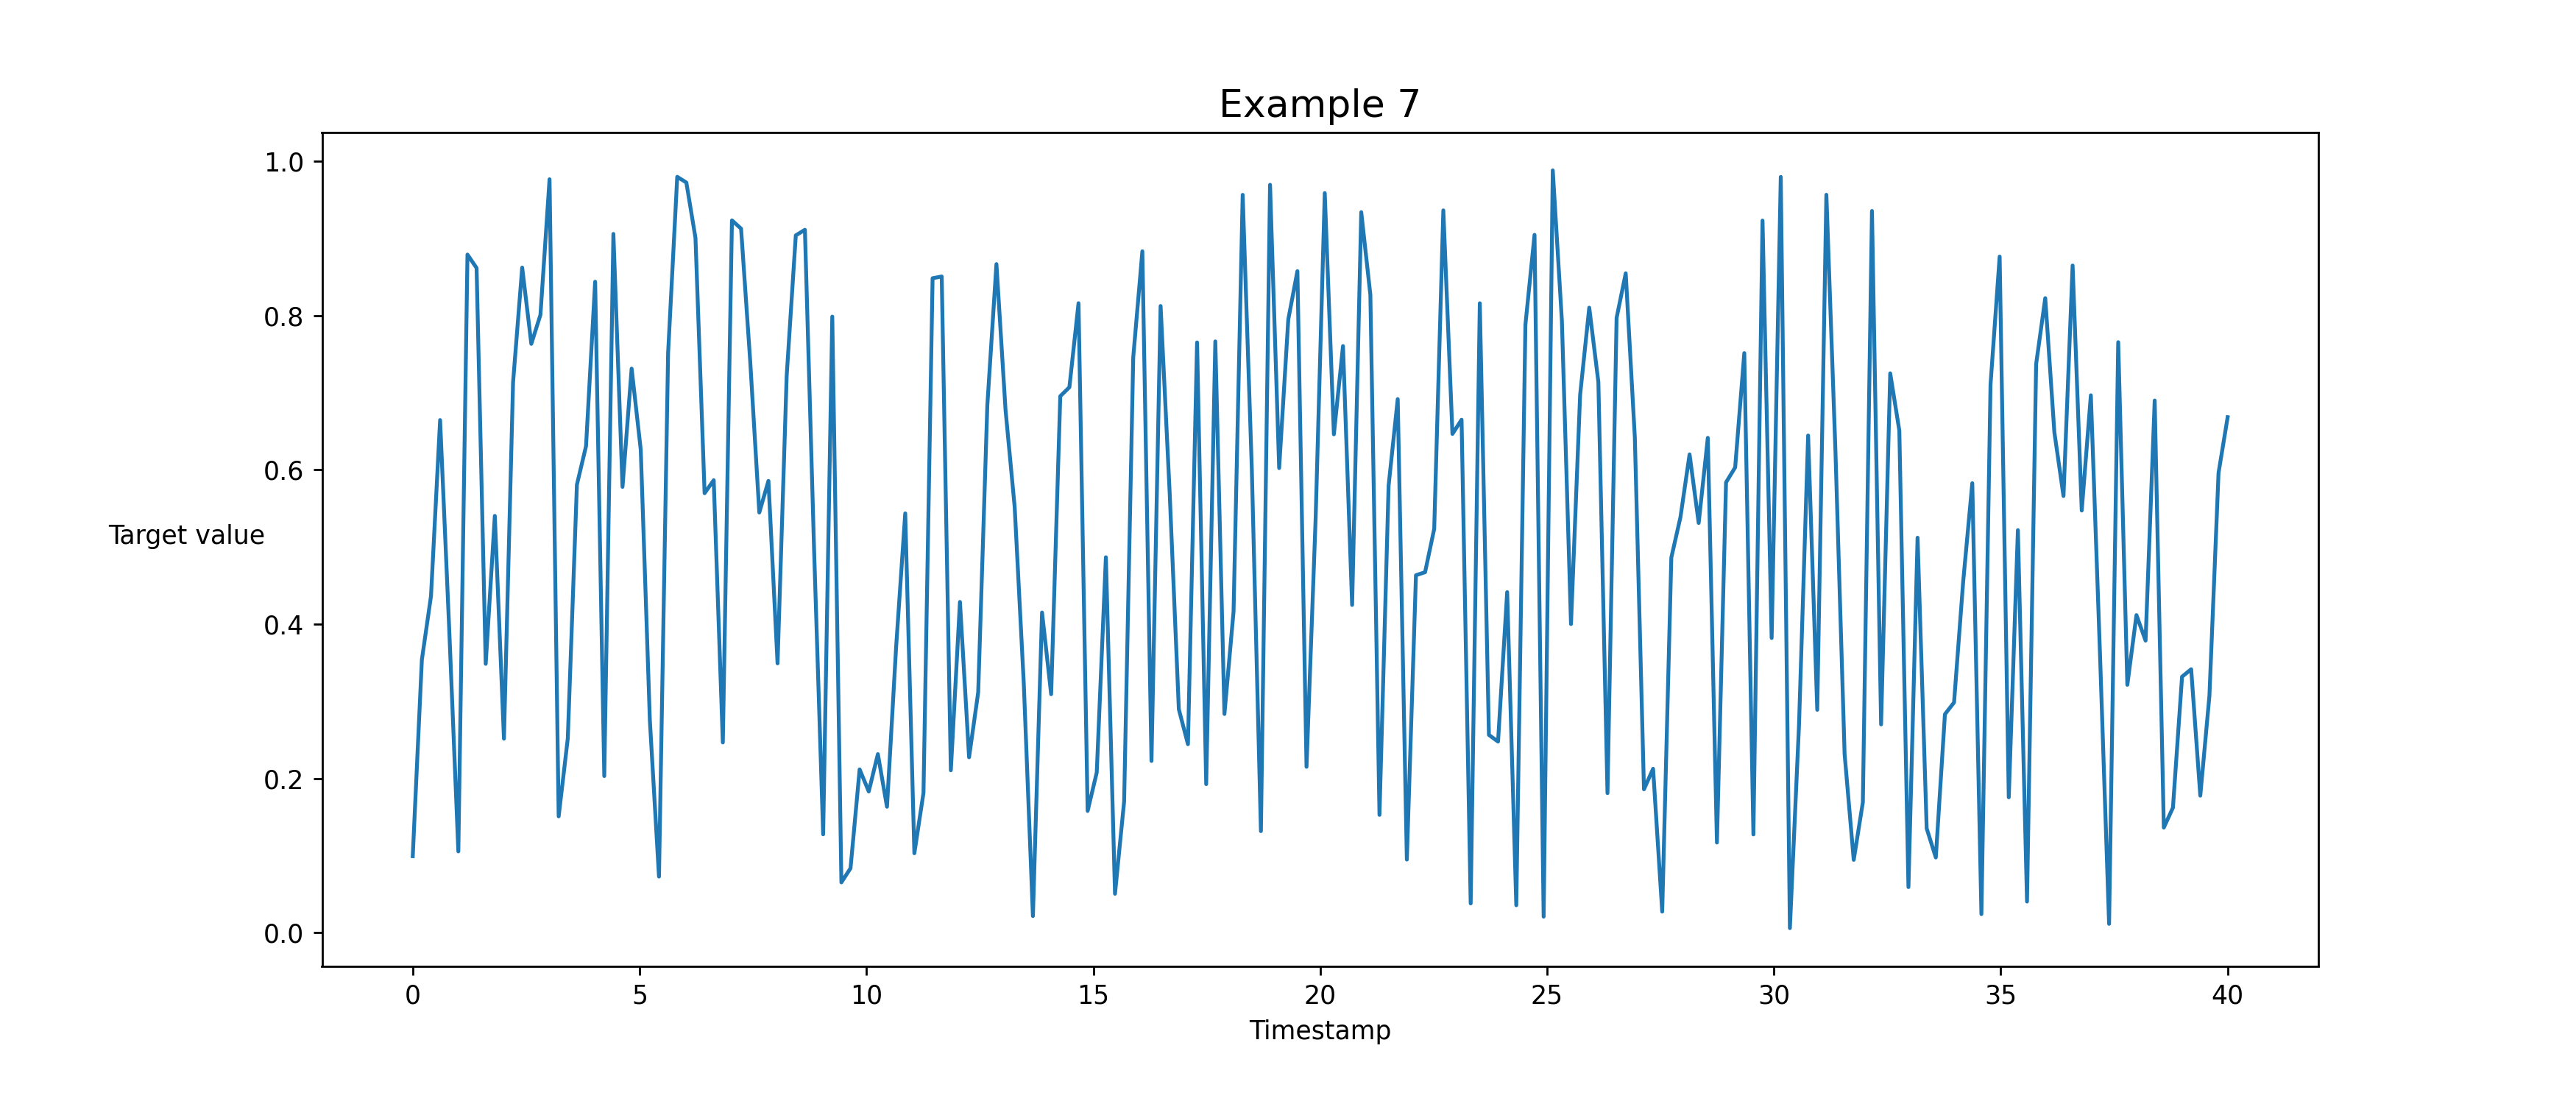

In [8]:
Image('./example_7.png')

## Пример временного ряда:

In [8]:
# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
#df = pd.read_csv('./train.csv')
df = pd.read_csv('./example_data.csv')
df.head(13)

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

      datetime    total
0   01-01-1985  72.5052
1   02-01-1985  70.6720
2   03-01-1985  62.4502
3   04-01-1985  57.4714
4   05-01-1985  55.3151
5   06-01-1985  58.0904
6   07-01-1985  62.6202
7   08-01-1985  63.2485
8   09-01-1985  60.5846
9   10-01-1985  56.3154
10  11-01-1985  58.0005
11  12-01-1985  68.7145
12  01-01-1986  73.3057

In [10]:
df.shape

(397, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  397 non-null    object 
 1   total     397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [12]:
# Проанализируем базовые статистики имеющихся признаков
df.describe()

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

            total
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800

In [13]:
df.replace(np.nan, 0, inplace=True)

In [14]:
# Привидём время к типу 'datetime' и сделаем его индексом для датасета
df['datetime'] = pd.to_datetime(df['datetime'], format='%m-%d-%Y') #%d.%m.%Y %H:%M:%S

df = df.set_index(['datetime'])
df.sort_index(inplace=True)
df.head()

AttributeError: 'NotebookFormatter' object has no attribute 'get_result'

              total
datetime           
1985-01-01  72.5052
1985-02-01  70.6720
1985-03-01  62.4502
1985-04-01  57.4714
1985-05-01  55.3151

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_110439/3037788219.py", line 6, in <cell line: 6>
    df['total'].plot();
  File "/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/pandas/plotting/_core.py", line 869, in __call__
    [f"{name}={repr(value)}" for (name, _), value in zip(arg_def, args)]
  File "/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/pandas/plotting/_core.py", line 1780, in _get_plot_backend
ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback


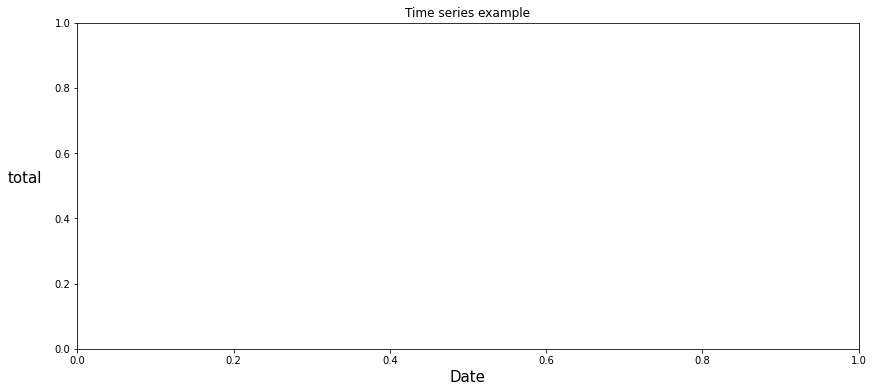

In [15]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
plt.title('Time series example')
plt.xlabel('Date', fontsize=15)
plt.ylabel('total', rotation=0, labelpad=30, fontsize=15)
df['total'].plot();

Вопросы:
- Есть ли у данного ряда тренд? 
- Есть ли у данного ряда сезонность?

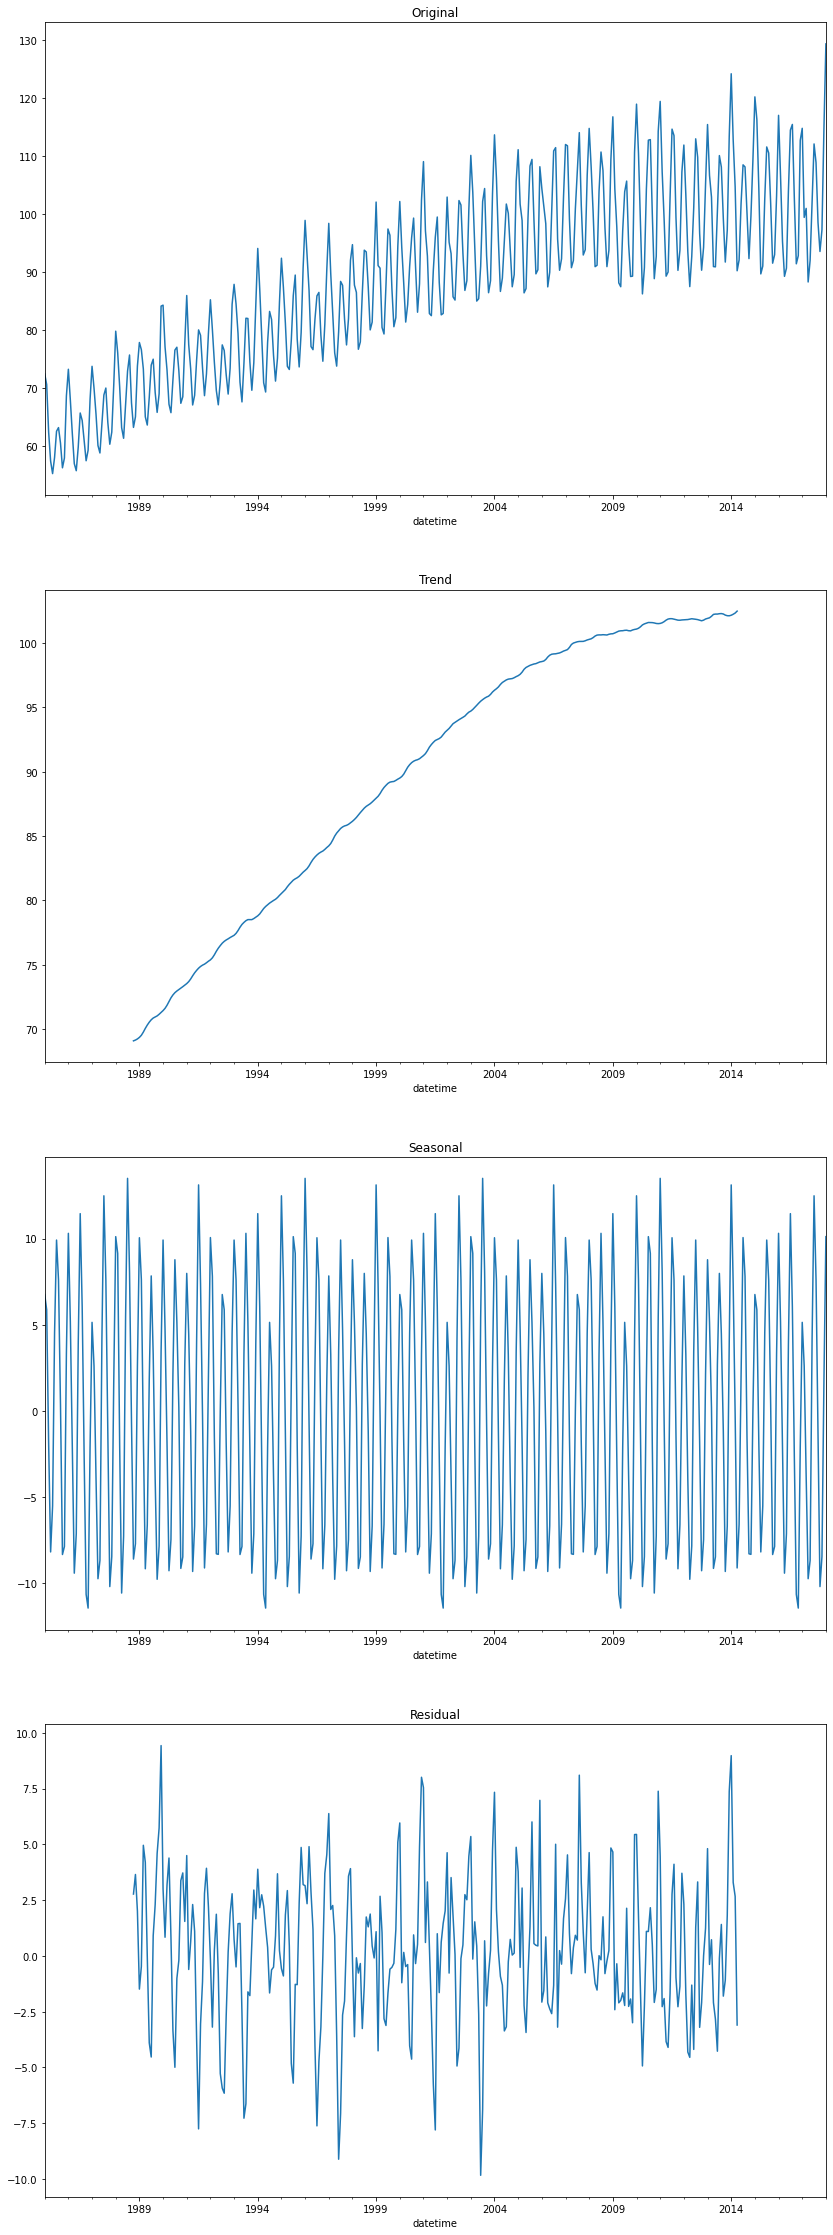

In [17]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['total']], period=90)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Для последующего анализа нам потребуется ввести термин "Автокорреляция", который позволит нам более подробно изучить свойства временных рядов

## Автокорреляция

### Автокорреляция &#151; мера силы линейной связи между значениями ряда в настоящем или прошлом

###  $$r_t = \frac{\mathbb{E}((y_t - \mathbb{E}y)(y_{t + \tau} - \mathbb{E}y))}{\mathbb{D}y}$$ 
$\tau$ &#151; лаг автокорреляции

$r_t \in [-1; 1]$

In [18]:
# Получил 'сырые' значения автокорреляций
acf(df['total'], nlags=60, fft=False)

array([1.        , 0.86277906, 0.63640377, 0.52487459, 0.61398953,
       0.8028675 , 0.88986545, 0.78414523, 0.58354441, 0.488432  ,
       0.5944013 , 0.7975361 , 0.90427102, 0.7819278 , 0.56651747,
       0.46030659, 0.55354872, 0.73918453, 0.82055665, 0.7169618 ,
       0.52063329, 0.42631338, 0.52756829, 0.7243959 , 0.82125003,
       0.70318342, 0.4994603 , 0.39833997, 0.48936333, 0.66826858,
       0.74889194, 0.64978222, 0.4599157 , 0.37077794, 0.46892315,
       0.65689318, 0.75156214, 0.63836795, 0.43981197, 0.3411746 ,
       0.42660681, 0.59837871, 0.67525862, 0.57899029, 0.39680261,
       0.31207849, 0.40779669, 0.59120161, 0.6851493 , 0.5729622 ,
       0.37728615, 0.28094817, 0.36375444, 0.52948883, 0.60286428,
       0.50953742, 0.33505788, 0.25519727, 0.34643671, 0.52298727,
       0.61440856])

На самом же деле, с автокорреляциями удобнее работать имея перед глазами график, поэтому далее нам необходимо рассмотреть коррелограммы

### Корелограммы

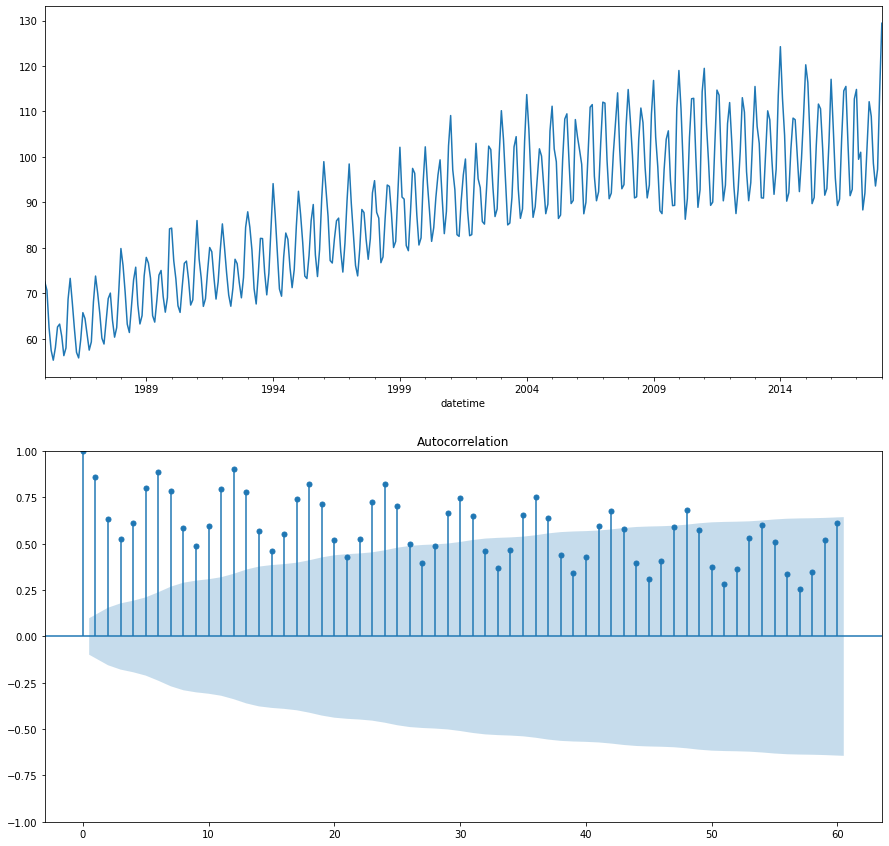

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df['total'].plot(ax=ax[0])
plot_acf(df['total'], lags=60, ax=ax[1]);

На втором графике каждый столбец -- значение автокорреляции, а зона, обозначенная синим, говорит о том, является ли определённая автокорреляция значимой (выходит из зоны) или нет (весь столбец находится в закрашенной области)

## Стационарность

Ряд $y_1, y_2, \cdots, y_T$ является **стационарным**, если для любого окна ширины $s$ распределение ряда $y_t, \cdots, y_{t+s}$ не зависит от выбора $t$

Некоторые полезные хинты для проверки ряда на стационарность:

- если у ряда есть тренд, то он нестационарен;
- если у ряда есть сезонность, то он нестационарен;
- если у ряда изменяется со временем дисперсия, то он нестационарен.

Есть ли критерий для проверки ряда на стационарность?

Ответ: Можно воспользоваться аппаратом проверки гипотез. В частности метод (тест) Дики-Фуллера

In [20]:
p_value = adfuller(df['total'])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.1862. 0.1862 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!


Как сделать ряд стационарным?

- дифференцирование ряда (простое и сезонное);
- преобразование Бокса-Кокса;
- логарифмирование ряда (частный случай преобразования Бокса-Кокса).

### Попробуем привести ряд к стационарному

In [21]:
df.head()

,total
datetime,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [22]:
df['totalDiff_1'] = df['total'] - df['total'].shift(1) # Тут вроде можно использовать df['total'].diff(), но это не точно
df.head()

,total,totalDiff_1
datetime,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


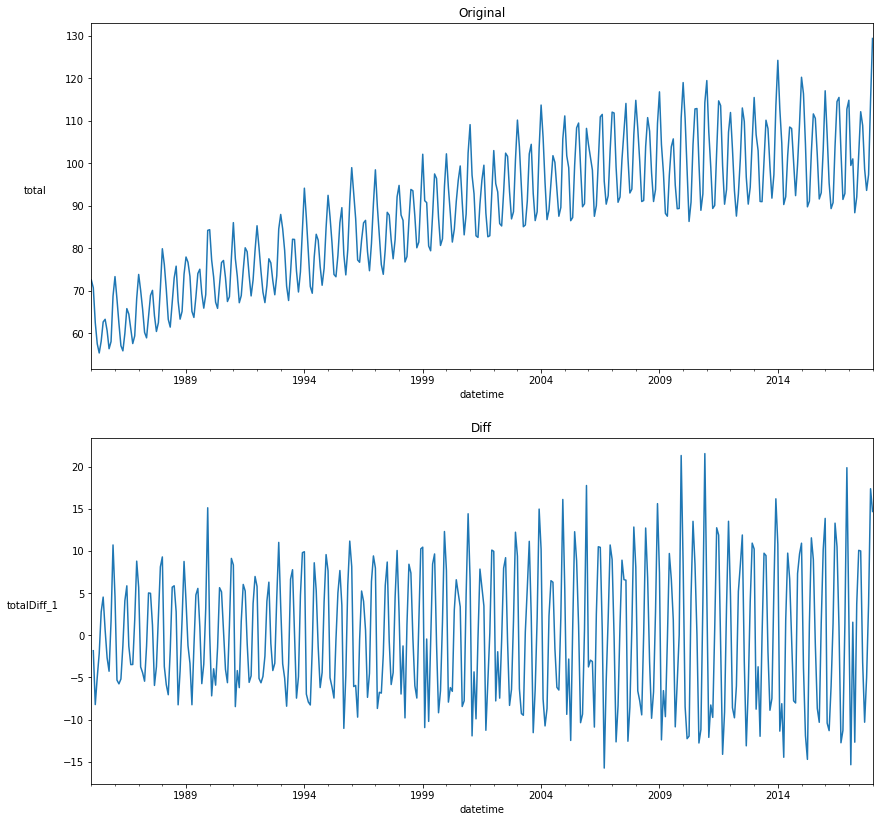

In [23]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('total', rotation=0, labelpad=30)
df['total'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('totalDiff_1', rotation=0, labelpad=30)
df['totalDiff_1'].plot(ax=ax);

In [24]:
# Проверим гипотезы для нового ряда

p_value = adfuller(df['totalDiff_1'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

# Но на самом деле ряд не стационарный (после 2020 года дисперсия увеличилась)
# Критерий не даёт нам 100-процентную гарантию, он просто может выступать в качестве первичной проверки

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


In [25]:
# Используем трюк с логарифмированием для уменьшения дисперсии и так же как и ранее составим диффериенцированный ряд
df['totalLog'] = np.log(df['total'])
df['totalLogDiff_1'] = df['totalLog'] - df['totalLog'].shift(1)
df.head()

,total,totalDiff_1,totalLog,totalLogDiff_1
datetime,,,,
1985-01-01,72.5052,NaN,4.283658,NaN
1985-02-01,70.6720,-1.8332,4.258049,-0.025609
1985-03-01,62.4502,-8.2218,4.134369,-0.123680
1985-04-01,57.4714,-4.9788,4.051287,-0.083082
1985-05-01,55.3151,-2.1563,4.013046,-0.038242


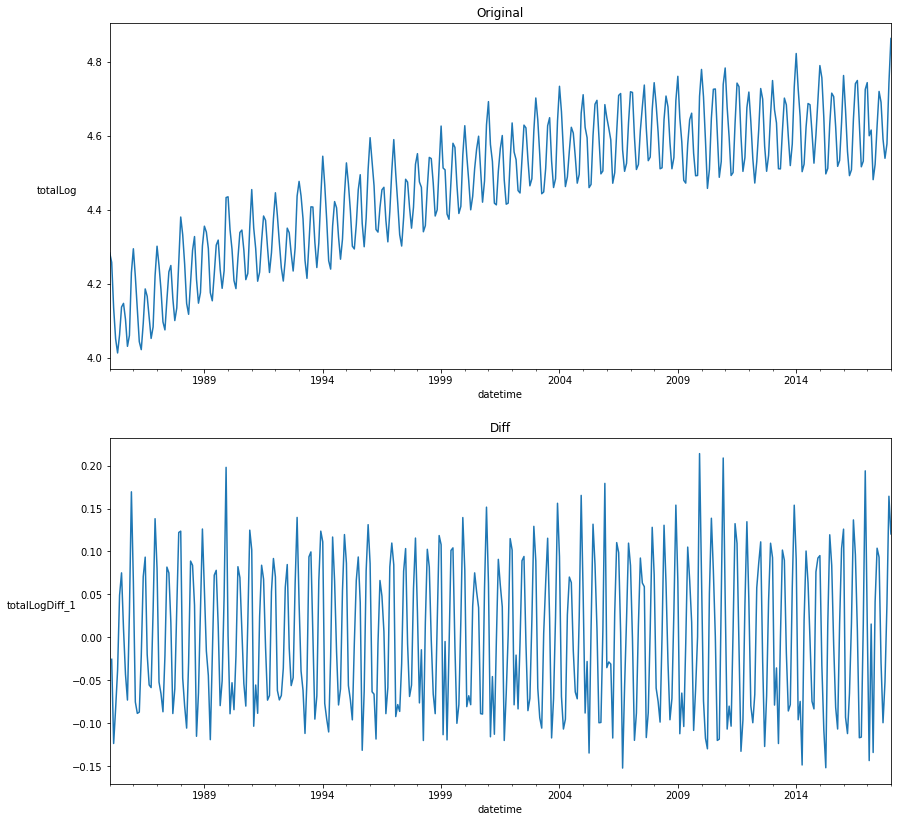

In [26]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('totalLog', rotation=0, labelpad=30)
df['totalLog'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('totalLogDiff_1', rotation=0, labelpad=30)
df['totalLogDiff_1'].plot(ax=ax);

In [27]:
p_value = adfuller(df['totalLogDiff_1'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)


Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


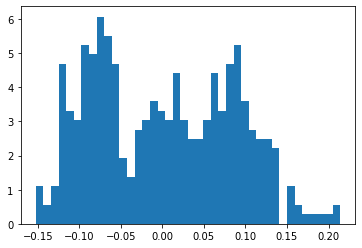

In [28]:
plt.hist(df['totalLogDiff_1'], density=True, bins=40);
# Как можно видеть распредение признака 'totalLogDiff_1' не очень похоже на нормальное

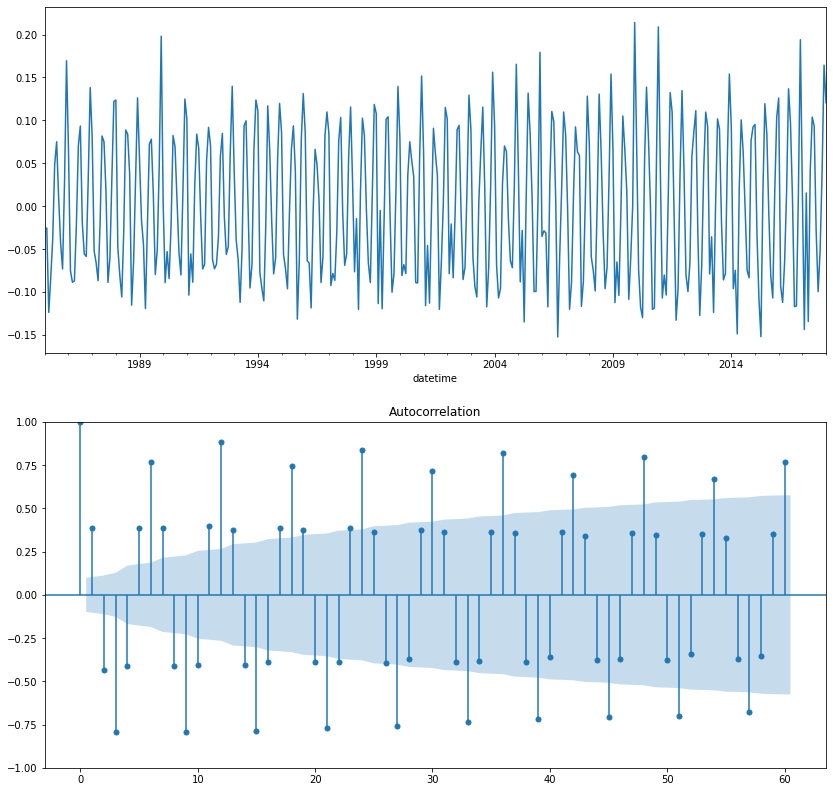

In [29]:
# Построим корелограмму и проверим наличие значимых коррелаций
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['totalLogDiff_1'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['totalLogDiff_1'][1:], lags=60, ax=ax);

Дано множество $Y_1$, $Y_2$, $Y_3$, $Y_4$, ...


А где $X$-ы?

Ответ:
* $X$-ы можно получить из метки времени, если знать периоды.
* $X$-ы можно получить из $Y$ - обобщённая авторегрессия.




In [30]:
from statsmodels.tsa.ar_model import AutoReg

In [31]:
train = pd.read_csv("train.csv")
train

,datetime,total
0,01.01.2005 00:00:00,NaN
1,01.01.2005 01:00:00,154139.8084
2,01.01.2005 02:00:00,157818.3593
3,01.01.2005 03:00:00,149310.6991
4,01.01.2005 04:00:00,138282.0380
...,...,...
35059,31.12.2008 19:00:00,249376.3608
35060,31.12.2008 20:00:00,246510.5725
35061,31.12.2008 21:00:00,226469.4133
35062,31.12.2008 22:00:00,199907.3942


In [32]:
#train.fillna(method='bfill', inplace=True)
train.fillna(value=0.0, inplace=True)
train

,datetime,total
0,01.01.2005 00:00:00,0.0000
1,01.01.2005 01:00:00,154139.8084
2,01.01.2005 02:00:00,157818.3593
3,01.01.2005 03:00:00,149310.6991
4,01.01.2005 04:00:00,138282.0380
...,...,...
35059,31.12.2008 19:00:00,249376.3608
35060,31.12.2008 20:00:00,246510.5725
35061,31.12.2008 21:00:00,226469.4133
35062,31.12.2008 22:00:00,199907.3942


In [33]:
series = train.total.values

In [34]:
ar = AutoReg(series, lags=168).fit()

In [35]:
prediction = ar.predict(start=35064, end=35064+4344-1, dynamic=False)

In [36]:
sample = pd.read_csv("sample.csv")
sample

,datetime,total
0,01.01.2009 00:00:00,0
1,01.01.2009 01:00:00,0
2,01.01.2009 02:00:00,0
3,01.01.2009 03:00:00,0
4,01.01.2009 04:00:00,0
...,...,...
4339,30.06.2009 19:00:00,0
4340,30.06.2009 20:00:00,0
4341,30.06.2009 21:00:00,0
4342,30.06.2009 22:00:00,0


In [37]:
sample["total"] = prediction
sample

,datetime,total
0,01.01.2009 00:00:00,141795.160409
1,01.01.2009 01:00:00,122348.849896
2,01.01.2009 02:00:00,109032.275479
3,01.01.2009 03:00:00,101638.328050
4,01.01.2009 04:00:00,102951.070940
...,...,...
4339,30.06.2009 19:00:00,212913.340459
4340,30.06.2009 20:00:00,216702.634163
4341,30.06.2009 21:00:00,213963.365730
4342,30.06.2009 22:00:00,203491.605539


In [38]:
sample.to_csv("prediction.csv", index=False)

## ARMA

Использовать обыкновенную регрессию для предсказания значений временного ряда плохая идея.

Попробуем решать задачу регрессии на основе истории самого ряда:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \epsilon_t$$ 
где $\alpha, \theta_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ называется моделью авторегрессии с гиперпараметром $p$, **AR(p)**.




Ещё одна идея:

Попробуем решать задачу регрессии на основе истории остатков ряда:

### $$y_t = \alpha + \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t - q} + \epsilon_t$$ 
где $\alpha, \gamma_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ называется моделью скользящего среднего с гиперпараметром $q$, **MA(q)**.

Если же мы представим $y_t$ в следующем виде:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t-q} + \epsilon_t$$ 

где $\alpha, \theta_i, \gamma_i$ &#151; параметры модели, то мы получим модель под названием **ARMA(p, q)** с гиперпараметрами $p$ и $q$.

## ARIMA

Основные идеи, которые лежат в основе модели ARIMA:

- если мы имеем стационарный ряд, то мы можем использовать модель ARMA(p, q);
- если ряд нестационарен, то ряд его производных (сезонных или обычных) может оказаться стационарным.

### ARIMA(p, d, q) &#151; ARMA(p, q), которая применяется к исходному ряду, продиффериенцированному $d$ раз.

## SARMA

Пусть исходный ряд имеет сезонность длины $S$.

Добавим к модели **ARMA(p, q)** $P$ сезонных авторегресионных компонент и $Q$ сезонных компонент скользащего среднего

тогда формула для $y_t$ будет выглядеть следующим образом:

### $$y_t = \alpha + \theta_1 y_{t-1} + \theta_2 y_{t-2}, \cdots, \theta_{p} y_{t-p} + \\ \theta_S y_{t-S} + \theta_{2S} y_{t-2S}, \cdots, \theta_{PS} y_{t-PS} + \\ \gamma_1 \epsilon_{t-1} + \gamma_2 \epsilon_{t-2}, \cdots, \gamma_{q} \epsilon_{t-q} + \\ \gamma_S \epsilon_{t-S} + \gamma_{2S} \epsilon_{t-2S}, \cdots, \gamma_{QS} \epsilon_{t-QS} + \epsilon_t$$ 

где $\alpha, \theta_i, \gamma_i$ &#151; параметры модели

Такая модель для предсказания значений $y_t$ является моделью **SARMA(p, q, P, Q)**.

## SARIMA (последнее обобщение)

Пусть исходный ряд также имеет сезонность длины $S$.

Добавим к модели **ARIMA(p, d, q)** $P$ сезонных авторегресионных компонент, $Q$ сезонных компонент скользащего среднего и применим сезонное дифференцирование $D$ раз.

Такая модель для предсказания значений $y_t$ является моделью **SARIMA(p, d, q, P, D, Q)**.

### **SARIMA(p, d, q, P, D, Q)** &#151; **SARMA(p, q, P, Q)**, которая применяется к исходному ряду, продиффериенцированному $D + d$ раз.



## Подбор параметров для алгоритмов

###  1. Параметры $\alpha$, $\theta_i$, $\gamma_i$

- данные параметры подбираются при помощи метода наименьших квадратов (МНК);
- особый интерес представляют параметры $\gamma_i$, так как $\epsilon_t$ не может быть пронаблюдаем нами (это просто шум);
- для этого параметры $\gamma_i$ оцениваются с помощью анализа остатков, который был произведён после обучении модели **AR(p, P)**;
- если шум белый, то МНК даёт оценки максимального правдоподобия (это круто).

### 2. Параметры d, D

- подобрать так, чтобы ряд стал стационарным (брутфорс?);
- стоит начинать именно с сезонного дифференцирования (параметра $D$);
- чем меньше мы в итоге продифференцируем, тем лучше будет итоговая модель.

### 3. Параметры q, Q, p, P

- нельзя подбирать эти параметры только на основе оценки правдоподобия (почему?);
- обычно для их выбора используют критерий Акаике: $AIC = -2\log{L} + 2 \cdot(P + Q + p + q + 1)$;
- начальные значения можно выбрать используя автокорреляцию;
- после этого параметры q, Q, p, P подбираются простым перебором.

- $Q \cdot S$ &#151; номер последнего сезонного лага, для которого автокорреляция значима;
- $q$ &#151; номер последнего несезонного лага, для которого автокорреляция значима;
- $P \cdot S$ &#151; номер последнего сезонного лага, для которого частичная автокорреляция значима;
- $p$ &#151; номер последнего несезонного лага, для которого частичная автокорреляция значима.


In [39]:
import statsmodels.api as sm
p = 1
d = 1
q = 1

P = 1
D = 1
Q = 1
model = sm.tsa.statespace.SARIMAX(df['total'], order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp=-1)
print(model.summary())

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              total   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -888.613
Date:                            Mon, 18 Jul 2022   AIC                           1787.226
Time:                                    13:35:43   BIC                           1806.979
Sample:                                01-01-1985   HQIC                          1795.061
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5249      0.045     11.764      0.000       0.437       0.612
ma.L1         -0.9547      0.018   

## Анализ остатков

**Остатки** &#151; разность между фактическим значением и прогнозируемым.

### $$\hat{\epsilon_t} = y_t - \hat{y_t}$$

Предположения, которым должны подчиняться остатки:

- несмещенность (равенство среднего значения остатков нулю). Можно проверить как визуально, так и с помощью двустороннего критерия Стьюдента или Уилкоксона. Если не выполняется, то можно вручную сдвинуть значения модели на среднее от остатков;
- стационарность (отсутствие зависимости от времени). Можно проверить как визуально, так и с критерия Дики-Фуллера. Если не выполняется, то точность модели зависит от времени. Необходим визуальный анализ;
- неавтокоррелируемость (отсутствие зависимости от предыдущих остатков). 